# Prediction on Breast Cancer Data

## An introduction to the dataset

The dataset Wisconsin Diagnostic Breast Cancer (WDBC) was created on 1995 by Dr. W.Wolberg, W.Nick and O. Mangasarian. It is available through the UW CS ftp server: http://ftp.cs.wisc.edu/math-prog/cpo-dataset/machine-learn/cancer/WDBC/. 

The dataset contains 569 observations with 33 features. These features are measured from a digitized image of a fine needle aspirate (FNA) of a breast mass. The following is a complete description of the features, cited from the paper.
### Now Let's import all the tools we need in the analysis

#### Section 1: Basic Tools for Manipulation and Visualization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import pydot
from IPython.display import Image

#### Section 2: Important Tools for Machine Learning

In [3]:
import pkg_resources
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.externals.six import StringIO
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_auc_score
from scikitplot.metrics import plot_confusion_matrix
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans

The following function creates images of tree models using pydot

In [4]:
def print_tree(estimator, features, class_names=None, filled=True):
    tree=estimator
    names=features
    color=filled
    classn=class_names
    
    dot_data=StringIO()
    export_graphviz(estimator, out_file=dot_data,feature_names=features, class_names=classn, filled=filled)
    graph=pydot.graph_from_dot_data(dot_data.getvalue())
    return(graph)

# Explore the data
#### load the data set

In [5]:
breast=pd.read_csv('./Breast_Cancer_data.csv')
breast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

The `Unnamed:32` feature contains all the Na or useless observations so we drop it. The `id` is not useful in the analysis. `diagnosis` is a binary variable and the response variable we would like to predict.

In [6]:
breast.columns
breast=breast.drop(['Unnamed: 32','id'], axis=1)

In [7]:
breast.head(2)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902


In [8]:
breast.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


/Users/dingxuanzhang/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


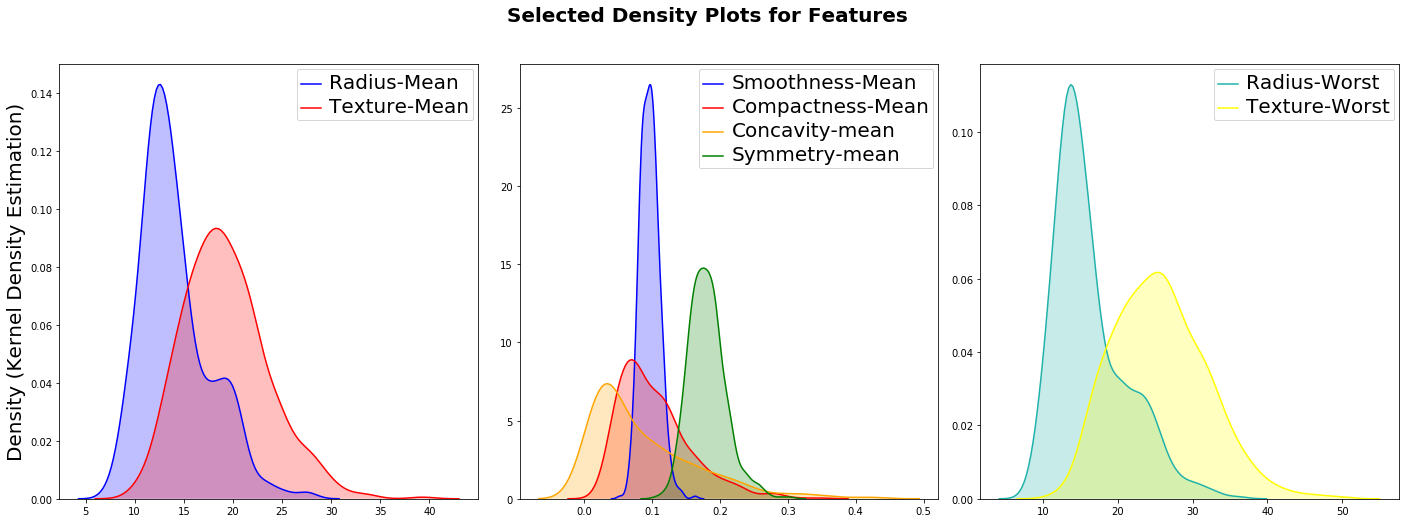

In [9]:
f, (ax1, ax2, ax3)=plt.subplots(ncols=3, sharex=False, sharey=False)
f.set_figheight(8)
f.set_figwidth(24)

# Group Density Plots for the first two features
sns.kdeplot(breast.radius_mean,ax=ax1, shade=True, color='b', label='Radius-Mean')
sns.kdeplot(breast.texture_mean, ax=ax1,shade=True, color='r', label='Texture-Mean')

# Group Density Plots for smoothness mean and compactness-mean
sns.kdeplot(breast.smoothness_mean, shade=True, color='b', ax=ax2, label='Smoothness-Mean')
sns.kdeplot(breast.compactness_mean, shade=True, color='r',ax=ax2, label='Compactness-Mean')
sns.kdeplot(breast.concavity_mean, shade=True, color='orange',ax=ax2, label='Concavity-mean')
sns.kdeplot(breast.symmetry_mean, shade=True, color='green',ax=ax2, label='Symmetry-mean')

# Supper Group Density Plots
sns.kdeplot(breast.radius_worst, shade=True, color='lightseagreen', ax=ax3, label='Radius-Worst')
sns.kdeplot(breast.texture_worst, shade=True, color='yellow', ax=ax3, label='Texture-Worst')

# Adjust the middle space between plots
plt.subplots_adjust(wspace=0.1)

# Set the title for the plots
f.suptitle('Selected Density Plots for Features',
           fontweight='bold',fontsize=20)

# Because we share y label, it is enough setting common ylabel
ax1.set_ylabel('Density (Kernel Density Estimation)', fontsize=20)


# Set the best size of legend
plt.setp(ax1.get_legend().get_texts(), fontsize='20')
plt.setp(ax2.get_legend().get_texts(), fontsize='20')
plt.setp(ax3.get_legend().get_texts(), fontsize='20')
plt.show()

There are 357 observations labeled benign status, comparing with 212 labeled malignant status.

Number of Benign: 357
Number of Malignant: 212


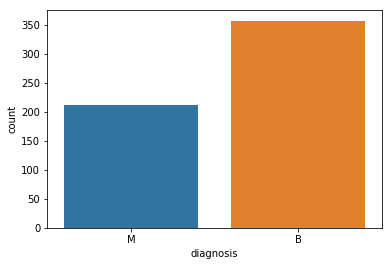

In [10]:
#Plot the frequency of cancer stages
sns.countplot(breast['diagnosis'], label='Count')
B, M =breast.diagnosis.value_counts()
print('Number of Benign:', B)
print('Number of Malignant:', M)
plt.savefig('./Counts_Outcome.png')

## Selecting Features

In [11]:
y=breast.diagnosis.map({'M':1, 'B':0})

In [12]:
features=breast.drop('diagnosis', axis=1)
features.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## Classification Tree Model without Clustering

#### First, Split the data into training and test

In [13]:
features_train, features_test, y_train, y_test= train_test_split(features,y, test_size=0.3, random_state=0)

In [14]:
y_train.value_counts()

0    249
1    149
Name: diagnosis, dtype: int64

In [15]:
y_test.value_counts()

0    108
1     63
Name: diagnosis, dtype: int64

In [16]:
Clft=DecisionTreeClassifier()
Clft.fit(features_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

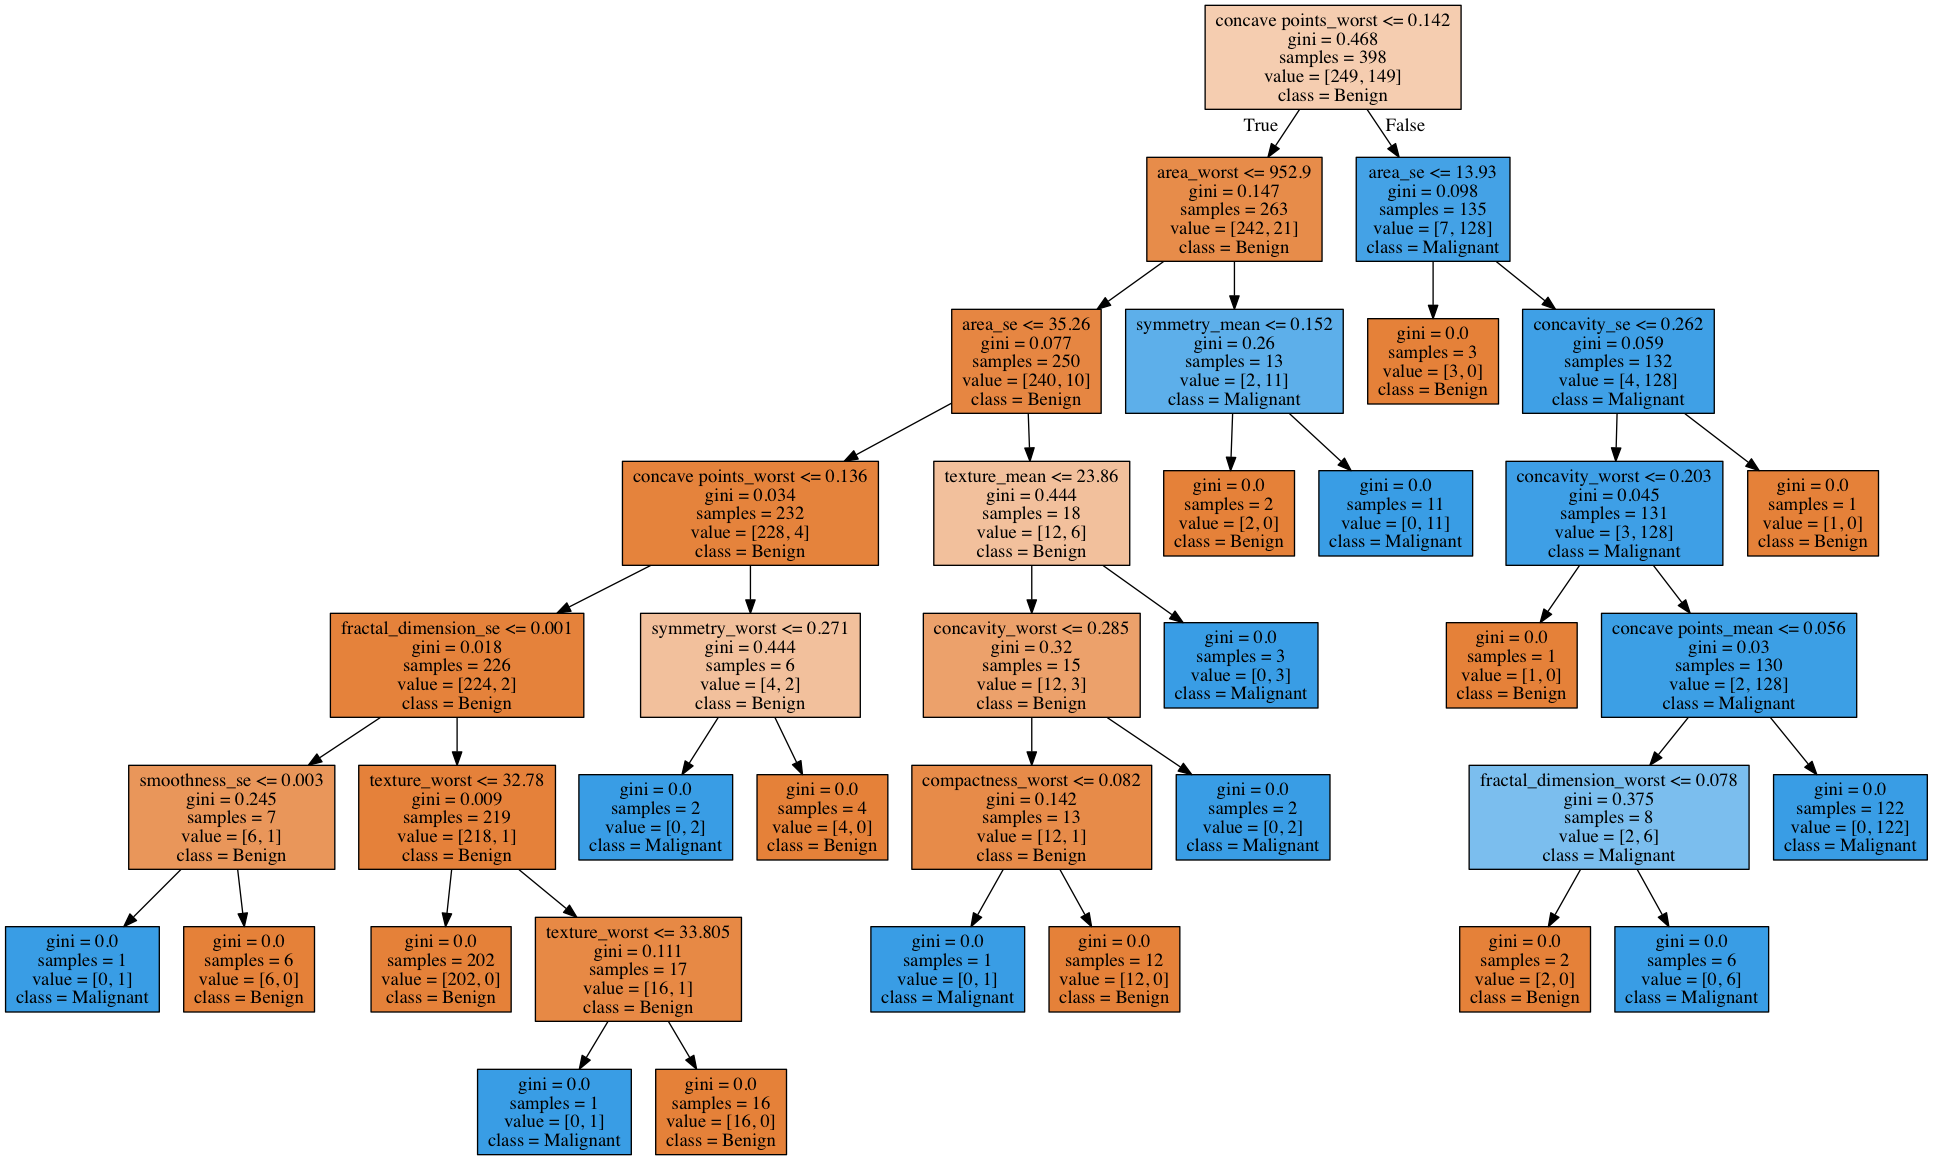

In [17]:
grapht,=print_tree(Clft, features=features_train.columns, class_names=['Benign','Malignant'])
Image(grapht.create_png())

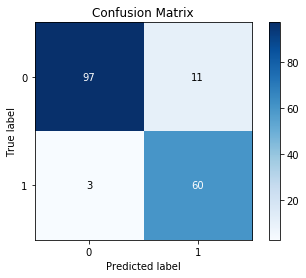

In [18]:
plot_confusion_matrix(y_test, Clft.predict(features_test))

## Prune the complete classification tree with 4 folds cross-validation

In [19]:
tree_sizes=np.arange(2,31)

ACC=[]
AUC=[]

#4-fold CV for each tree-size
for size in tree_sizes:
    clft_tr=DecisionTreeClassifier(max_leaf_nodes=size, random_state=123)
    ACC_s=cross_val_score(clft_tr, features, y, cv=4, scoring='accuracy')
    AUC_s=cross_val_score(clft_tr, features, y, cv=4, scoring='roc_auc')
    ACC.append(np.mean(ACC_s))
    AUC.append(np.mean(AUC_s))

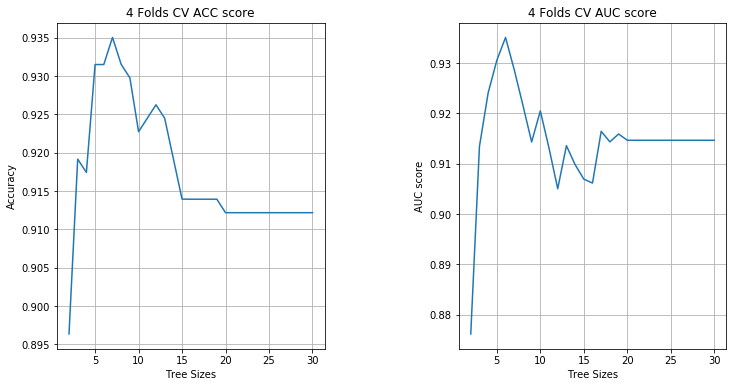

In [20]:
#Plot CV-Accuracy and AUC scores with respect to tree size
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(wspace=0.5)

##Plot the first CV-Accuracy
ax1.plot(tree_sizes, ACC)
ax1.set_xlabel('Tree Sizes')
ax1.set_ylabel('Accuracy')
ax1.set_title('4 Folds CV ACC score')
ax1.grid(True)

##Plot the second AUC
ax2.plot(tree_sizes, AUC)
ax2.set_xlabel('Tree Sizes')
ax2.set_ylabel('AUC score')
ax2.set_title('4 Folds CV AUC score')
ax2.grid(True)

## It seems that 7 is the optimal terminal nodes.

#### Now let's prune the complete classification tree

In [21]:
CLFT=DecisionTreeClassifier(max_leaf_nodes=7)
CLFT.fit(features_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=7, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

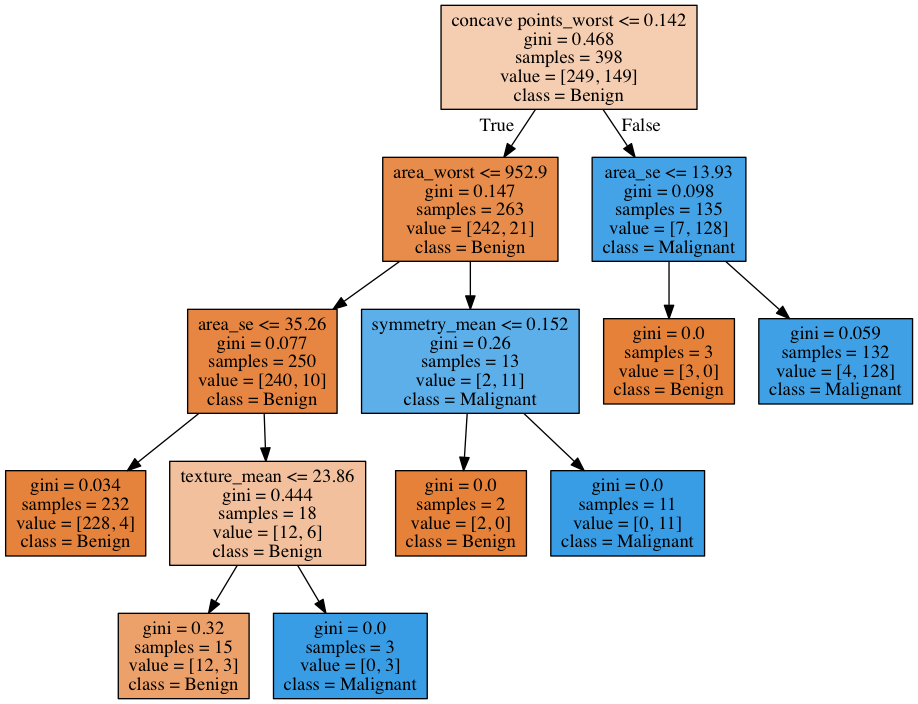

In [22]:
graphT,=print_tree(CLFT, features=features_train.columns, class_names=['Benign','Malignant'])
Image(graphT.create_png())

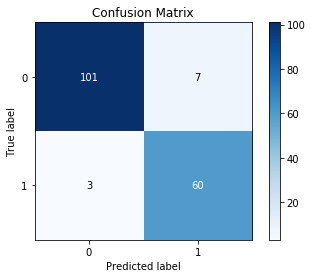

In [23]:
plot_confusion_matrix(y_test, CLFT.predict(features_test))

## Choose the best tree size with 10 folds cross validation

In [41]:
tree_sizes=np.arange(2,31)

ACC=[]
AUC=[]

#10-fold CV for each tree-size
for size in tree_sizes:
    clft_tr=DecisionTreeClassifier(max_leaf_nodes=size, random_state=123)
    ACC_s=cross_val_score(clft_tr, features, y, cv=10, scoring='accuracy')
    AUC_s=cross_val_score(clft_tr, features, y, cv=10, scoring='roc_auc')
    ACC.append(np.mean(ACC_s))
    AUC.append(np.mean(AUC_s))

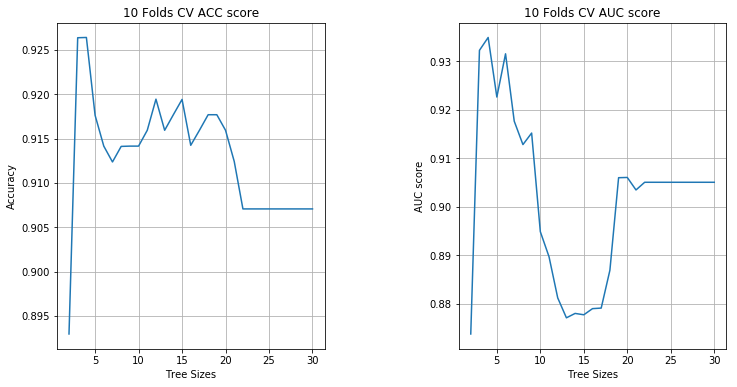

In [42]:
#Plot CV-Accuracy and AUC scores with respect to tree size
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(wspace=0.5)

##Plot the first CV-Accuracy
ax1.plot(tree_sizes, ACC)
ax1.set_xlabel('Tree Sizes')
ax1.set_ylabel('Accuracy')
ax1.set_title('10 Folds CV ACC score')
ax1.grid(True)

##Plot the second AUC
ax2.plot(tree_sizes, AUC)
ax2.set_xlabel('Tree Sizes')
ax2.set_ylabel('AUC score')
ax2.set_title('10 Folds CV AUC score')
ax2.grid(True)

In [43]:
CLFT=DecisionTreeClassifier(max_leaf_nodes=4)
CLFT.fit(features_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

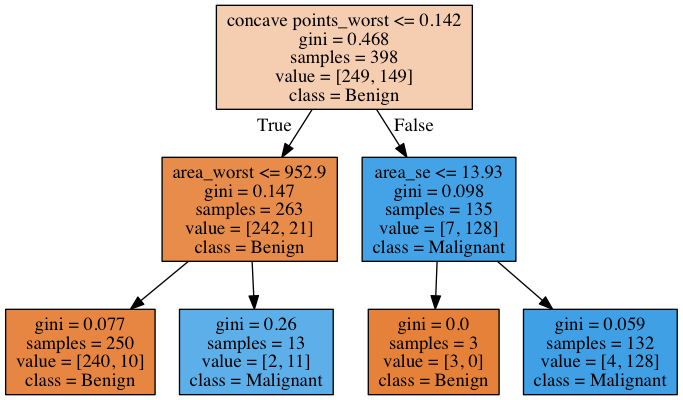

In [44]:
graphTt,=print_tree(CLFT, features=features_train.columns, class_names=['Benign','Malignant'])
Image(graphTt.create_png())

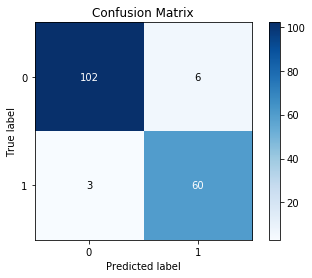

In [45]:
plot_confusion_matrix(y_test, CLFT.predict(features_test))

## Use the same selected features in the complete tree

In [25]:
FEA=features[feature_use]

#### Splite the data into training and test

In [26]:
FEA_train, FEA_test, y_train, y_test= train_test_split(FEA,y, test_size=0.3, random_state=0)

In [27]:
y_train.value_counts()

0    249
1    149
Name: diagnosis, dtype: int64

In [28]:
y_test.value_counts()

0    108
1     63
Name: diagnosis, dtype: int64

In [29]:
clft=DecisionTreeClassifier()
clft.fit(FEA_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

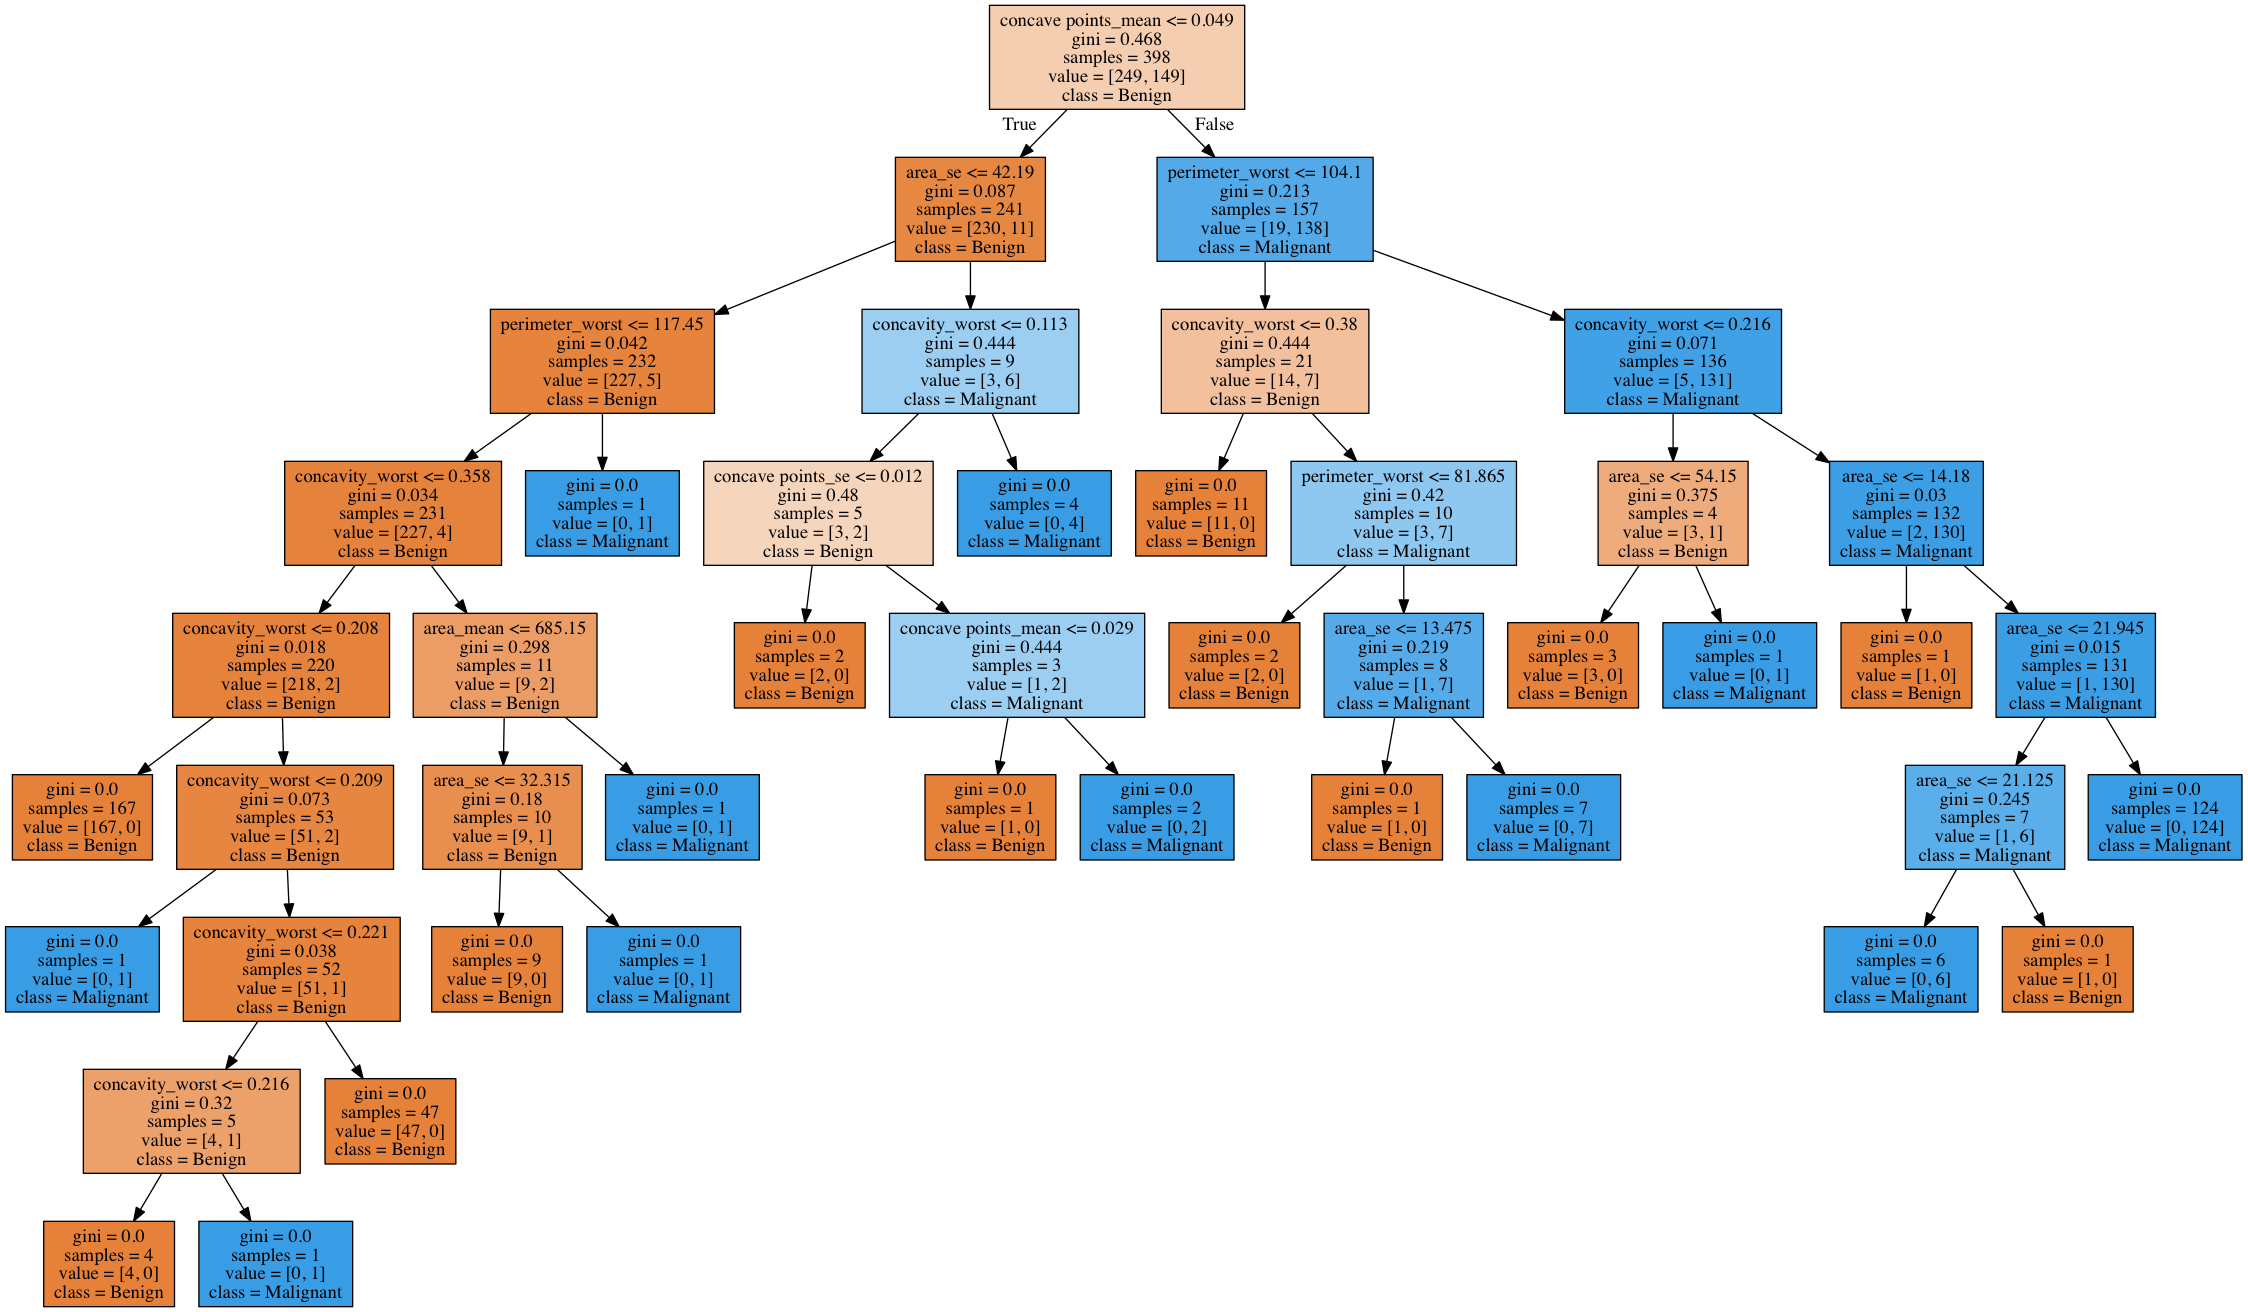

In [30]:
graphs,=print_tree(clft, features=FEA_train.columns, class_names=['Benign','Malignant'])
Image(graphs.create_png())

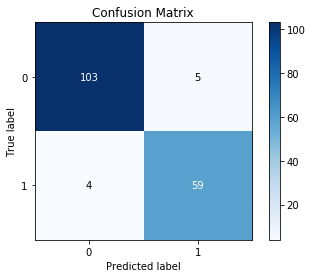

In [32]:
plot_confusion_matrix(y_test, clft.predict(FEA_test))

### Prune the selected variable tree

In [33]:
tree_sizes=np.arange(2,31)

ACC=[]
AUC=[]

#4-fold CV for each tree-size
for size in tree_sizes:
    clft_TR=DecisionTreeClassifier(max_leaf_nodes=size, random_state=123)
    ACC_s=cross_val_score(clft_TR, FEA, y, cv=4, scoring='accuracy')
    AUC_s=cross_val_score(clft_TR, FEA, y, cv=4, scoring='roc_auc')
    ACC.append(np.mean(ACC_s))
    AUC.append(np.mean(AUC_s))

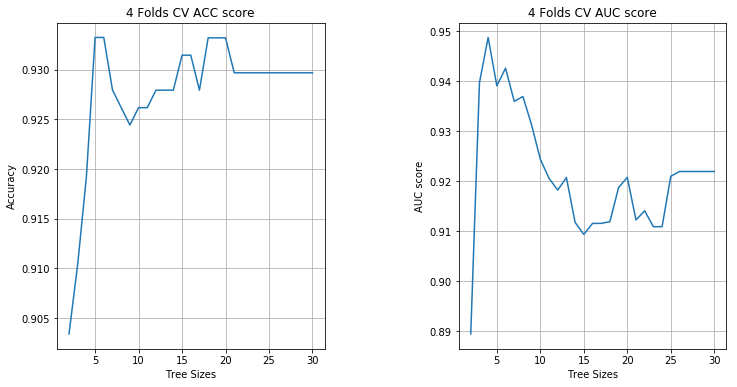

In [34]:
#Plot CV-Accuracy and AUC scores with respect to tree size
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(wspace=0.5)

##Plot the first CV-Accuracy
ax1.plot(tree_sizes, ACC)
ax1.set_xlabel('Tree Sizes')
ax1.set_ylabel('Accuracy')
ax1.set_title('4 Folds CV ACC score')
ax1.grid(True)

##Plot the second AUC
ax2.plot(tree_sizes, AUC)
ax2.set_xlabel('Tree Sizes')
ax2.set_ylabel('AUC score')
ax2.set_title('4 Folds CV AUC score')
ax2.grid(True)

#### It seems that 4 or 5 are best sizes. Let's try both.

In [35]:
CLFT5=DecisionTreeClassifier(max_leaf_nodes=5)
CLFT5.fit(FEA_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=5, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

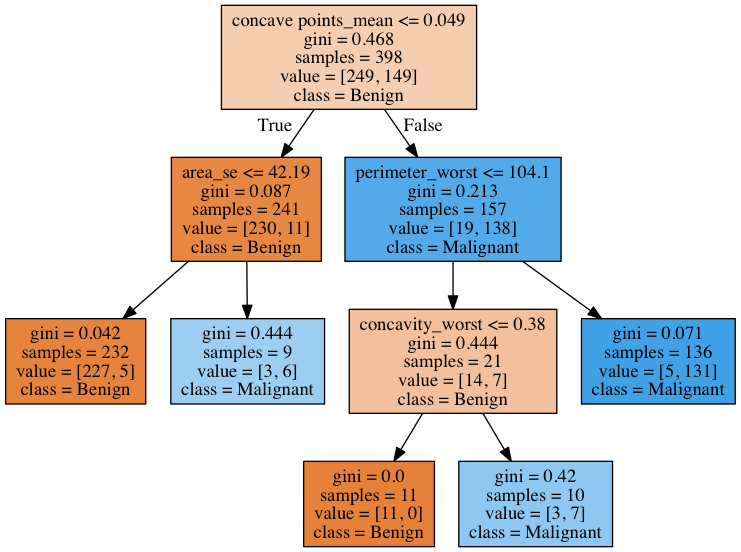

In [36]:
graph5,=print_tree(CLFT5, features=FEA_train.columns, class_names=['Benign','Malignant'])
Image(graph5.create_png())

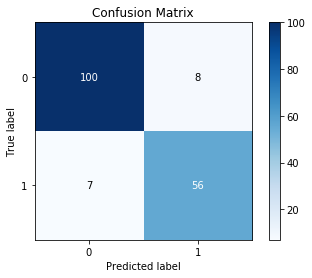

In [37]:
plot_confusion_matrix(y_test, CLFT5.predict(FEA_test))

In [38]:
CLFT4=DecisionTreeClassifier(max_leaf_nodes=4)
CLFT4.fit(FEA_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=4, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

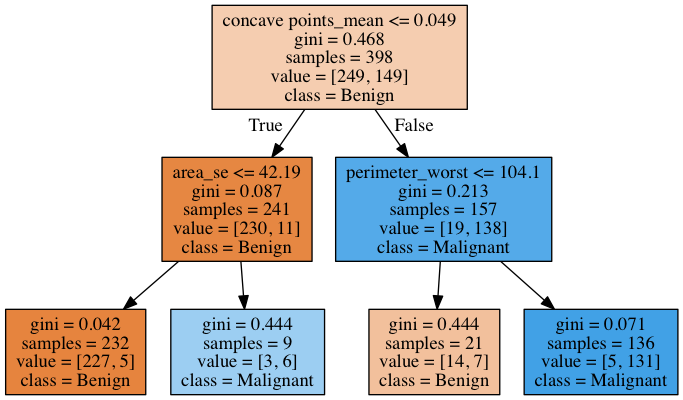

In [39]:
graph4,=print_tree(CLFT4, features=FEA_train.columns, class_names=['Benign','Malignant'])
Image(graph4.create_png())

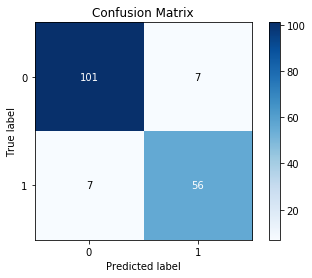

In [40]:
plot_confusion_matrix(y_test, CLFT4.predict(FEA_test))

#### Correlation Matrix

In [24]:
corr=features.corr()

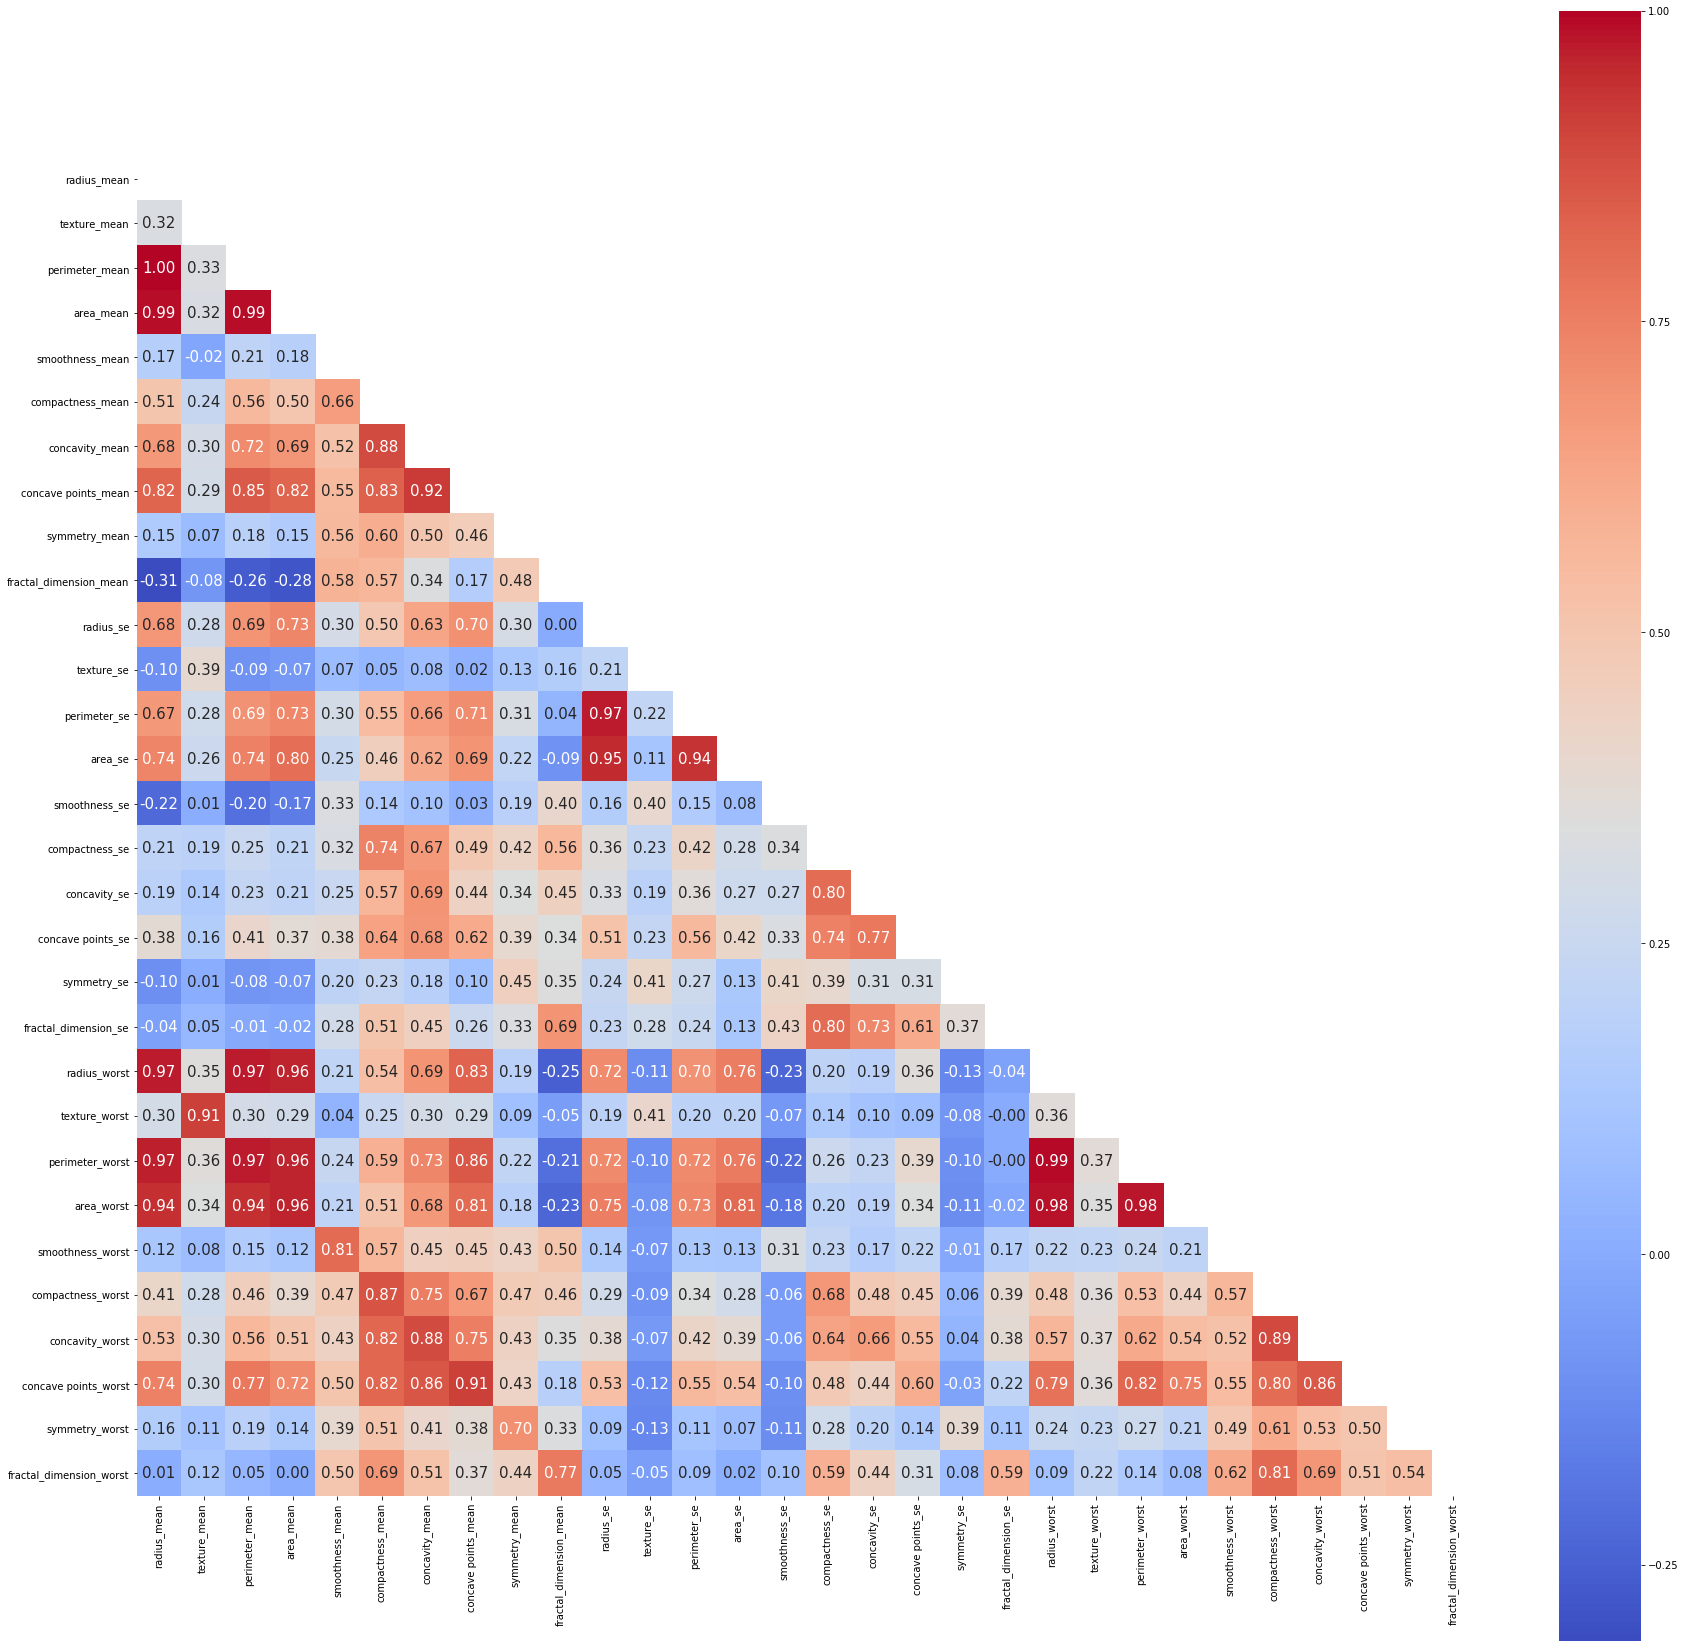

In [25]:
#Generate a mask for the upper triangle
mask=np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

plt.figure(figsize=(30,30))
sns.heatmap(corr,mask=mask, cbar=True, square=True, annot=True, fmt='.2f', annot_kws={'size':15},
           xticklabels=features.columns, yticklabels=features.columns, cmap='coolwarm')

As what we can see from the correlation matrix, there are some variables that are highly correlated. Let's try to investigate the correlation with variable suffix.

In [26]:
features.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

#### Subseting the features by different suffix

In [27]:
features_mean=features.columns[:10]

In [28]:
features_se=features.columns[10:20]

In [29]:
features_worst=features.columns[20:]

#### Standardized the data with different suffix

In [30]:
X_mean=features[features_mean]
X_mean_std=pd.DataFrame(scale(X_mean, with_mean=True, with_std=True), columns=X_mean.columns)
breast_mean=pd.concat([y, X_mean_std], axis=1)
breast_mean_plot=pd.melt(breast_mean, id_vars='diagnosis', var_name='features', value_name='value')

In [31]:
X_se=features[features_se]
X_se_std=pd.DataFrame(scale(X_se, with_mean=True, with_std=True), columns=X_se.columns)
breast_se=pd.concat([y, X_se_std], axis=1)
breast_se_plot=pd.melt(breast_se, id_vars='diagnosis', var_name='features', value_name='value')

In [32]:
X_worst=features[features_worst]
X_worst_std=pd.DataFrame(scale(X_worst, with_mean=True, with_std=True), columns=X_worst.columns)
breast_worst=pd.concat([y, X_worst_std], axis=1)
breast_worst_plot=pd.melt(breast_worst, id_vars='diagnosis', var_name='features', value_name='value')

Text(0.5, 0, 'Worst Group')

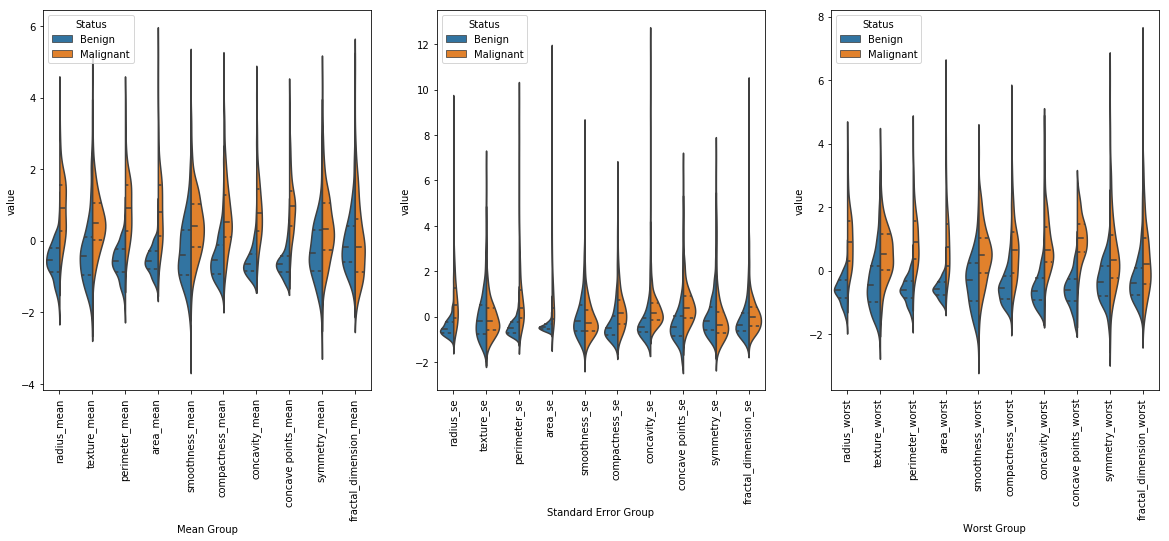

In [38]:
#Set the canvas for plotting
fig, axs=plt.subplots(1,3, figsize=(20, 7))
fig.subplots_adjust(wspace=0.2)


ax1=sns.violinplot(x='features', y='value', hue='diagnosis', data=breast_mean_plot, split=True, inner='quart', ax=axs[0])
for item in ax1.get_xticklabels():
    item.set_rotation(90)

ax2=sns.violinplot(x='features', y='value', hue='diagnosis', data=breast_se_plot, split=True, inner='quart', ax=axs[1])
for item in ax2.get_xticklabels():
    item.set_rotation(90)
    
ax3=sns.violinplot(x='features', y='value', hue='diagnosis', data=breast_worst_plot, split=True, inner='quart', ax=axs[2])
for item in ax3.get_xticklabels():
    item.set_rotation(90)
    
# Set legend Title and labels
handles, _ = ax1.get_legend_handles_labels()
ax1.legend(handles, ['Benign','Malignant'], title='Status', loc=2)

handles, _ = ax2.get_legend_handles_labels()
ax2.legend(handles, ['Benign','Malignant'], title='Status', loc=2)

handles, _ = ax3.get_legend_handles_labels()
ax3.legend(handles, ['Benign','Malignant'], title='Status', loc=2)

ax1.set_xlabel('Mean Group')
ax2.set_xlabel('Standard Error Group')
ax3.set_xlabel('Worst Group')


Look at the violin plots above. In mean-suffix plot, radius, perimeter, area, concavity, concave points have separated median, which indicate they can be good predictor for our model.

#### A similar implementation is visualized by swarmplot.

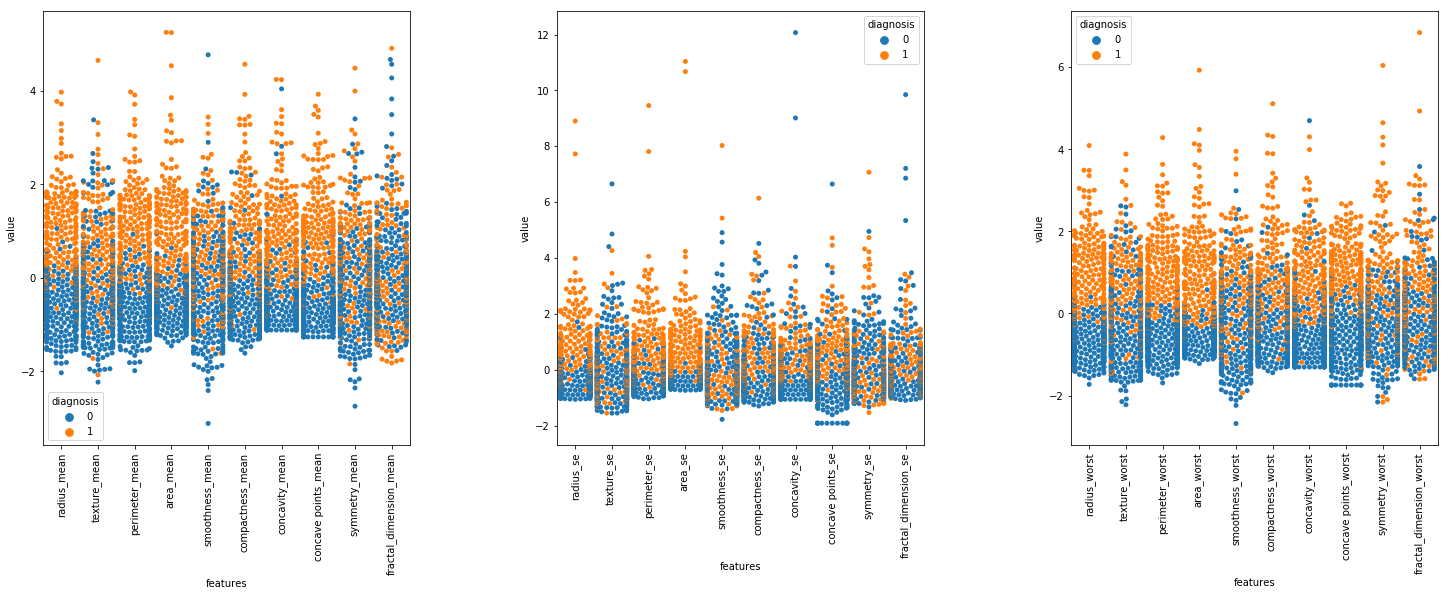

In [39]:
fig, axs=plt.subplots(1,3, figsize=(25, 8))
fig.subplots_adjust(wspace=0.4)

ax1=sns.swarmplot(x='features', y='value', hue='diagnosis', data=breast_mean_plot, ax=axs[0])
for item in ax1.get_xticklabels():
    item.set_rotation(90)

ax2=sns.swarmplot(x='features', y='value', hue='diagnosis', data=breast_se_plot, ax=axs[1])
for item in ax2.get_xticklabels():
    item.set_rotation(90)
    
ax3=sns.swarmplot(x='features', y='value', hue='diagnosis', data=breast_worst_plot, ax=axs[2])
for item in ax3.get_xticklabels():
    item.set_rotation(90)

# Use clustering to deal with correlated data

#### scale the data

In [23]:
features_std=pd.DataFrame(scale(features), columns=features.columns)
value=features_std.values

#### K-Means implementation

In [24]:
#Using the Elbow method to find a good number of clusters
elbow=[]
for ii in np.arange(1,21):
    kmeans=KMeans(n_clusters=ii, init='k-means++', n_init=10, max_iter=300)
    kmeans.fit_predict(value)
    elbow.append(kmeans.inertia_)

Text(0, 0.5, 'Within Cluster Sum of Squares')

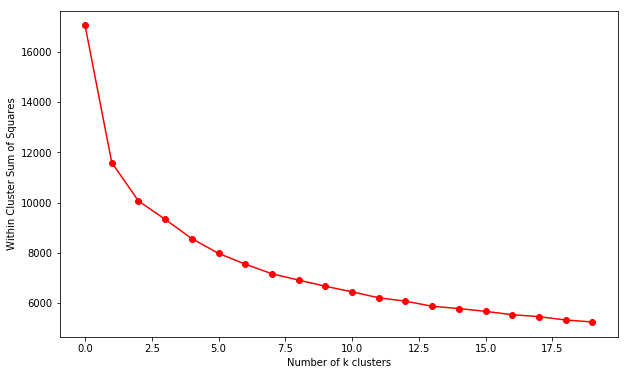

In [25]:
# Choosing k using Elbow method
plt.figure(figsize=(10,6))
plt.plot(elbow, 'ro-', label='Elbow')
plt.xlabel('Number of k clusters')
plt.ylabel('Within Cluster Sum of Squares')

#### Try k=2 

In [26]:
kmeans=KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300)
kmeans.fit(value)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [27]:
Pred=pd.Series(kmeans.fit_predict(value))

In [28]:
## Adding cluster label to our features dataset
features_std['cluster']=Pred

In [29]:
features_std.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,cluster
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015,1
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190,1
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391,1
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010,1
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100,1


In [30]:
#sns.pairplot(features_std, hue='cluster')

In [31]:
features.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [32]:
features_var=['radius_mean', 'perimeter_mean', 'area_mean',
       'compactness_mean', 'concavity_mean',
       'concave points_mean',
       'radius_se', 'perimeter_se', 'area_se',
       'concave points_se',
       'radius_worst', 
       'perimeter_worst', 'area_worst', 
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst']

In [33]:
value_var=pd.DataFrame(features_std[features_var].values)

In [34]:
pred=kmeans.fit_predict(value_var)
features_std['cluster']=pred
features_var.append('cluster')

In [35]:
#sns.pairplot(features_std[features_var], hue='cluster')

# Seperate the dataset by cluster

In [36]:
Breast_Features=pd.concat([y, features, features_std['cluster']], axis=1)
Breast_Features.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,cluster
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


In [37]:
Breast_0=Breast_Features[Breast_Features['cluster']==0]
Breast_1=Breast_Features[Breast_Features['cluster']==1]

### Now, let us do tree-based model on each cluster

In [24]:
feature_use=['area_mean','concave points_mean','area_se','perimeter_worst','concavity_worst','concave points_se']

### Select the features used in the tree-model

In [39]:
Breast_0_features=Breast_0[feature_use]
Breast_1_features=Breast_1[feature_use]

In [40]:
y_0=Breast_0['diagnosis']
y_1=Breast_1['diagnosis']

### Split the data into train and test

In [41]:
Breast_0_features_train, Breast_0_features_test, y_0_train, y_0_test=train_test_split(Breast_0_features, y_0, test_size=0.3, random_state=0)

In [42]:
Breast_1_features_train, Breast_1_features_test, y_1_train, y_1_test=train_test_split(Breast_1_features, y_1, test_size=0.3, random_state=0)

In [43]:
y_0_train.value_counts()

0    248
1     30
Name: diagnosis, dtype: int64

In [44]:
y_1_train.value_counts()

1    117
0      2
Name: diagnosis, dtype: int64

In [45]:
y_0_test.value_counts()

0    105
1     15
Name: diagnosis, dtype: int64

In [46]:
y_1_test.value_counts()

1    50
0     2
Name: diagnosis, dtype: int64

### Fitting the best tree size with Cross-Validation

#### Cluster 0

In [47]:
tree_sizes=np.arange(2,31)

ACC_0=[]
AUC_0=[]

# use 4-fold cv for each tree size
for size in tree_sizes:
    clf0_tr=DecisionTreeClassifier(max_leaf_nodes=size, random_state=0)
    ACC0_s=cross_val_score(clf0_tr, Breast_0_features, y_0, cv=4, scoring='accuracy')
    AUC0_s=cross_val_score(clf0_tr, Breast_0_features, y_0, cv=4, scoring='roc_auc')
    ACC_0.append(np.mean(ACC0_s))
    AUC_0.append(np.mean(AUC0_s))

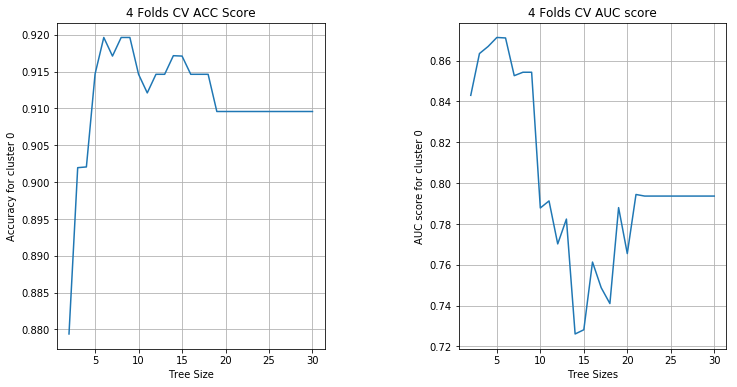

In [48]:
#Plot CV-Accuracy and AUC scores with respect to tree size
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(wspace=0.5)

#Plot the Accuracy
ax1.plot(tree_sizes, ACC_0)
ax1.set_xlabel('Tree Size')
ax1.set_ylabel('Accuracy for cluster 0')
ax1.set_title('4 Folds CV ACC Score')
ax1.grid(True)

#Plot the AUC score
ax2.plot(tree_sizes, AUC_0)
ax2.set_xlabel('Tree Sizes')
ax2.set_ylabel('AUC score for cluster 0')
ax2.set_title('4 Folds CV AUC score')
ax2.grid(True)

From the graph, we choose 6 leaf nodes.

In [49]:
clf_0=DecisionTreeClassifier(max_leaf_nodes=6)
clf_0.fit(Breast_0_features_train, y_0_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=6, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [50]:
print(classification_report(y_0_test, clf_0.predict(Breast_0_features_test)))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       105
           1       0.64      0.60      0.62        15

   micro avg       0.91      0.91      0.91       120
   macro avg       0.79      0.78      0.78       120
weighted avg       0.91      0.91      0.91       120



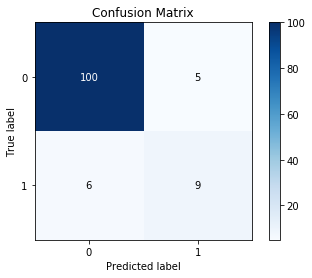

In [51]:
plot_confusion_matrix(y_0_test, clf_0.predict(Breast_0_features_test))

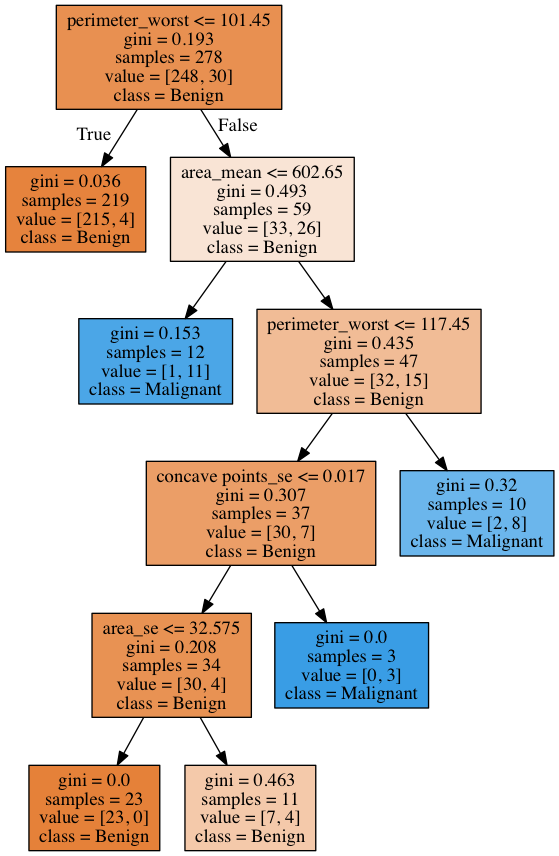

In [52]:
graph0, =print_tree(clf_0, features=Breast_0_features_train.columns, class_names=['Benign', 'Malignant'])
Image(graph0.create_png())

#### Cluster 1

In [53]:
tree_sizes=np.arange(2,31)

ACC_1=[]
AUC_1=[]

# use 7-fold cv for each tree size
for size in tree_sizes:
    clf1_tr=DecisionTreeClassifier(max_leaf_nodes=size, random_state=0)
    ACC1_s=cross_val_score(clf1_tr, Breast_1_features, y_1, cv=4, scoring='accuracy')
    AUC1_s=cross_val_score(clf1_tr, Breast_1_features, y_1, cv=4, scoring='roc_auc')
    ACC_1.append(np.mean(ACC1_s))
    AUC_1.append(np.mean(AUC1_s))

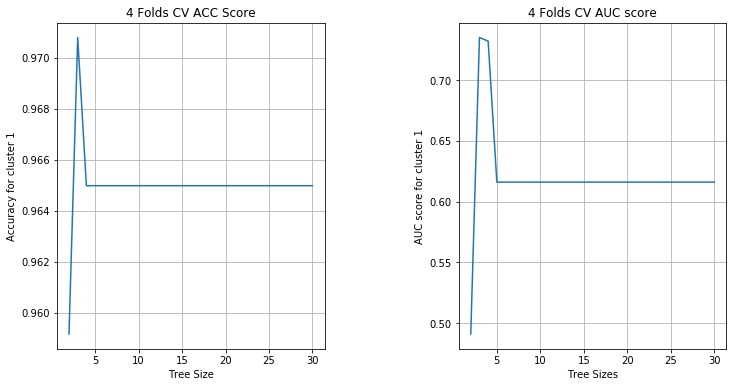

In [54]:
#Plot CV-Accuracy and AUC scores with respect to tree size
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(12,6))
fig.subplots_adjust(wspace=0.5)

#Plot the Accuracy
ax1.plot(tree_sizes, ACC_1)
ax1.set_xlabel('Tree Size')
ax1.set_ylabel('Accuracy for cluster 1')
ax1.set_title('4 Folds CV ACC Score')
ax1.grid(True)

#Plot the AUC score
ax2.plot(tree_sizes, AUC_1)
ax2.set_xlabel('Tree Sizes')
ax2.set_ylabel('AUC score for cluster 1')
ax2.set_title('4 Folds CV AUC score')
ax2.grid(True)

From the graph, we choose the leaf nodes 3.

In [55]:
clf_1=DecisionTreeClassifier(max_leaf_nodes=3)
clf_1.fit(Breast_1_features_train, y_1_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=3, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [56]:
print(classification_report(y_1_test, clf_1.predict(Breast_1_features_test)))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.98      1.00      0.99        50

   micro avg       0.98      0.98      0.98        52
   macro avg       0.99      0.75      0.83        52
weighted avg       0.98      0.98      0.98        52



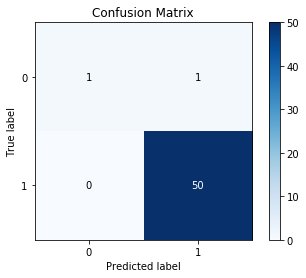

In [57]:
plot_confusion_matrix(y_1_test, clf_1.predict(Breast_1_features_test))

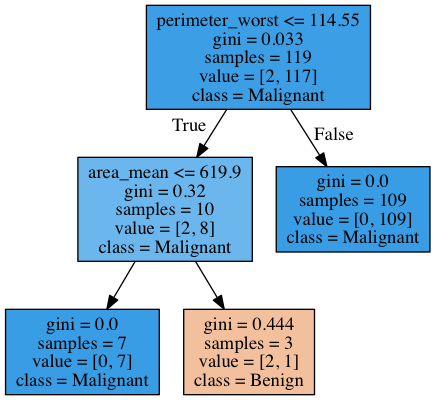

In [58]:
graph1, =print_tree(clf_1, features=Breast_1_features_train.columns, class_names=['Benign', 'Malignant'])
Image(graph1.create_png())